# Computing centralities from OSM data


Install and update `cityseer` if necessary.


In [1]:
# !pip install --upgrade cityseer

## Data and Extents

This example will make use of OSM data downloaded from the [OSM API](https://wiki.openstreetmap.org/wiki/API) for a 5000m radius around London Soho.

For additional information on network preparation, see the corresponding discussion on [graph cleaning](https://cityseer.benchmarkurbanism.com/guide#graph-cleaning).


In [2]:
from shapely import geometry

from cityseer.tools import graphs, io

# download from OSM
lng, lat = -0.13396079424572427, 51.51371088849723
buffer = 5000
plot_buffer = 3500
# creates a WGS shapely polygon
poly_wgs, poly_utm, _utm_zone_number, _utm_zone_letter = io.buffered_point_poly(lng, lat, buffer)
plot_bbox = poly_utm.centroid.buffer(plot_buffer).bounds

INFO:cityseer.tools.io:UTM conversion info: UTM zone number: 30, UTM zone letter: U


## Load

We can now load the OSM dataset and convert it to a format that can be used by cityseer for downstream calculations.


In [3]:
# generate OSM graph from polygon
G_utm = io.osm_graph_from_poly(poly_wgs, simplify=True, remove_parallel=True, iron_edges=False)
# decompose for higher resolution analysis
G_decomp = graphs.nx_decompose(G_utm, 25)
# prepare the data structures
nodes_gdf, _edges_gdf, network_structure = io.network_structure_from_nx(G_decomp, crs=32629)

INFO:cityseer.tools.io:Converting networkX graph from EPSG code 4326 to EPSG code 32630.
INFO:cityseer.tools.io:Processing node x, y coordinates.
100%|██████████| 152860/152860 [00:00<00:00, 504195.71it/s]
INFO:cityseer.tools.io:Processing edge geom coordinates, if present.
100%|██████████| 166306/166306 [00:00<00:00, 1042089.03it/s]
INFO:cityseer.tools.graphs:Generating interpolated edge geometries.
100%|██████████| 166306/166306 [00:05<00:00, 31268.23it/s]
INFO:cityseer.tools.graphs:Removing filler nodes.
100%|██████████| 152860/152860 [00:19<00:00, 7713.37it/s]
INFO:cityseer.tools.graphs:Removing dangling nodes.
100%|██████████| 43123/43123 [00:00<00:00, 321472.95it/s]
INFO:cityseer.tools.graphs:Removing filler nodes.
100%|██████████| 40280/40280 [00:00<00:00, 66266.76it/s]
INFO:cityseer.tools.graphs:Creating nodes STR tree
100%|██████████| 38256/38256 [00:00<00:00, 114749.48it/s]
INFO:cityseer.tools.graphs:Consolidating nodes.
100%|██████████| 38256/38256 [00:17<00:00, 2142.73it/s]

## Calculate centralities

The centrality methods can now be computed.


In [4]:
from cityseer.metrics import networks

# this will take around 5-6 minutes depending on the available resources
# if computing wider area centralities, e.g. 20km, then use less decomposition to speed up the computation
nodes_gdf = networks.node_centrality_shortest(
    network_structure=network_structure,
    nodes_gdf=nodes_gdf,
    distances=[250, 500, 2000],
)

100%|██████████| 94501/94501 [06:06<00:00, 257.84it/s]


## Plots

Let's plot a selection of distance thresholds for each of the computed measures.



    "Gravity" index / spatial impedance weighted (closeness-like) centrality:
    Avg walking tolerance: 87.80m
    Beta: 0.016 (spatial impedance factor)
    Max walking tolerance: 250.0m
    


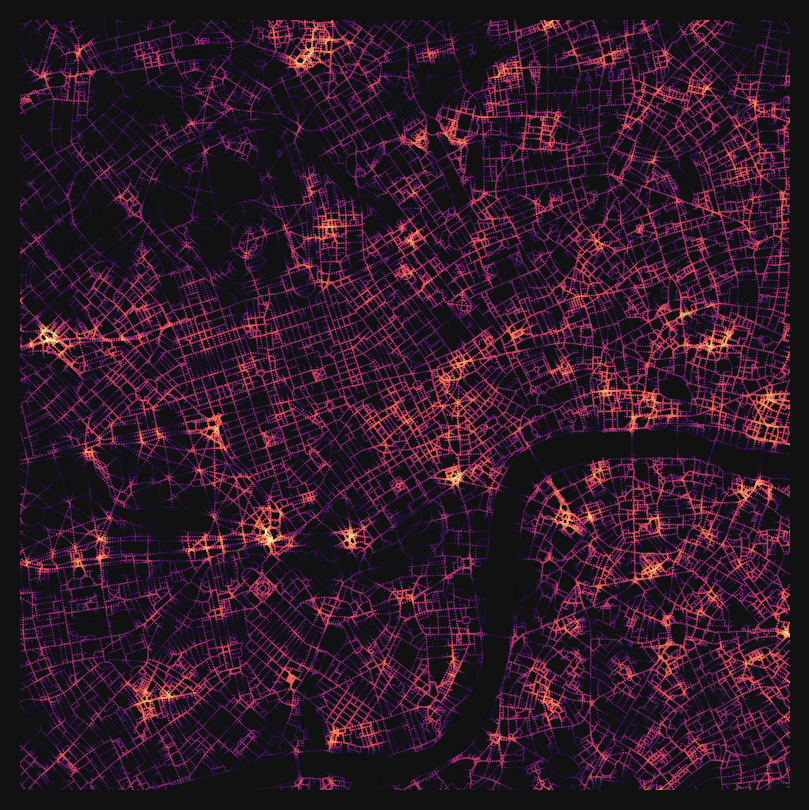


    "Gravity" index / spatial impedance weighted (closeness-like) centrality:
    Avg walking tolerance: 175.60m
    Beta: 0.008 (spatial impedance factor)
    Max walking tolerance: 500.0m
    


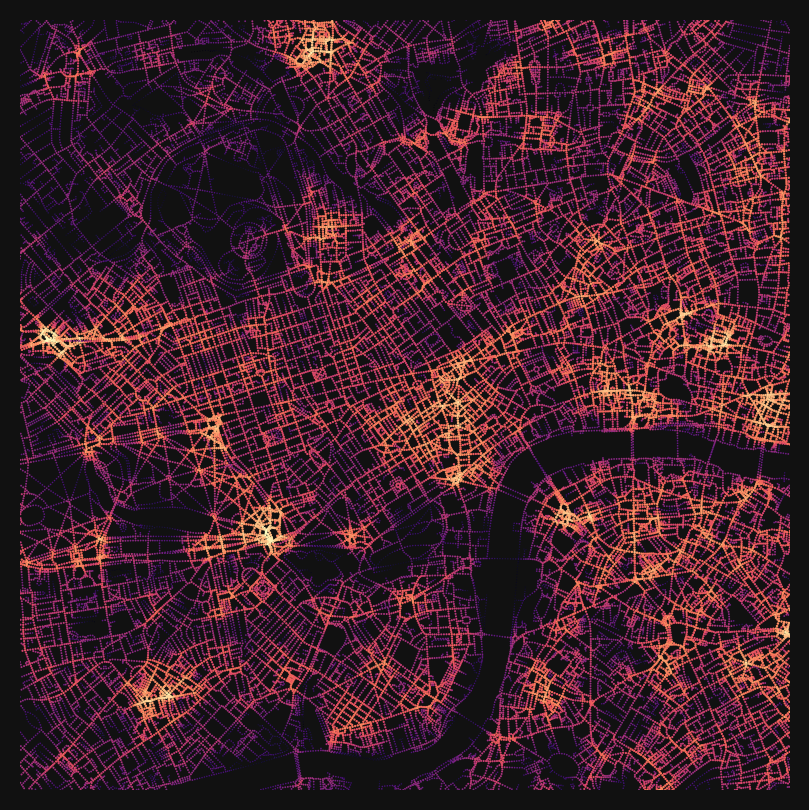


    "Gravity" index / spatial impedance weighted (closeness-like) centrality:
    Avg walking tolerance: 702.39m
    Beta: 0.002 (spatial impedance factor)
    Max walking tolerance: 2000.0m
    


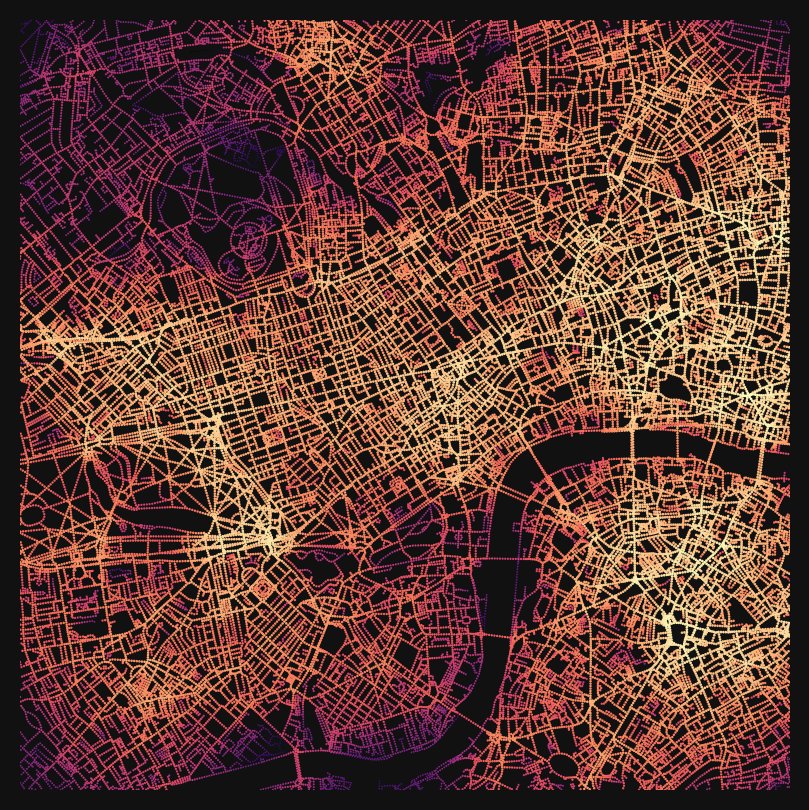


    Spatial impedance weighted betweenness centrality:
    Avg walking tolerance: 87.80m
    Beta: 0.016 (spatial impedance factor)
    Max walking tolerance: 250.0m
    


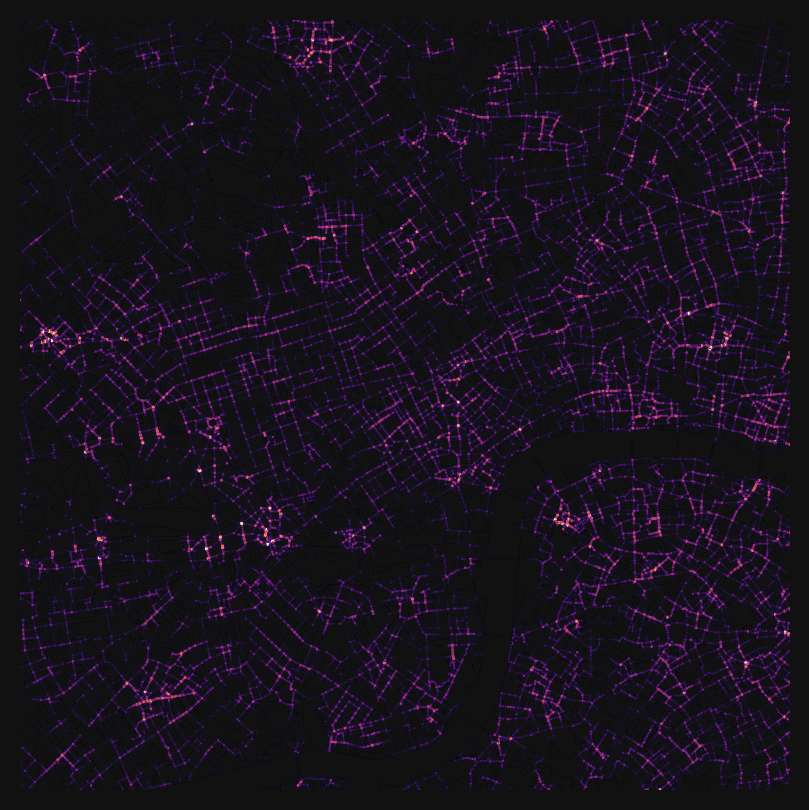


    Spatial impedance weighted betweenness centrality:
    Avg walking tolerance: 175.60m
    Beta: 0.008 (spatial impedance factor)
    Max walking tolerance: 500.0m
    


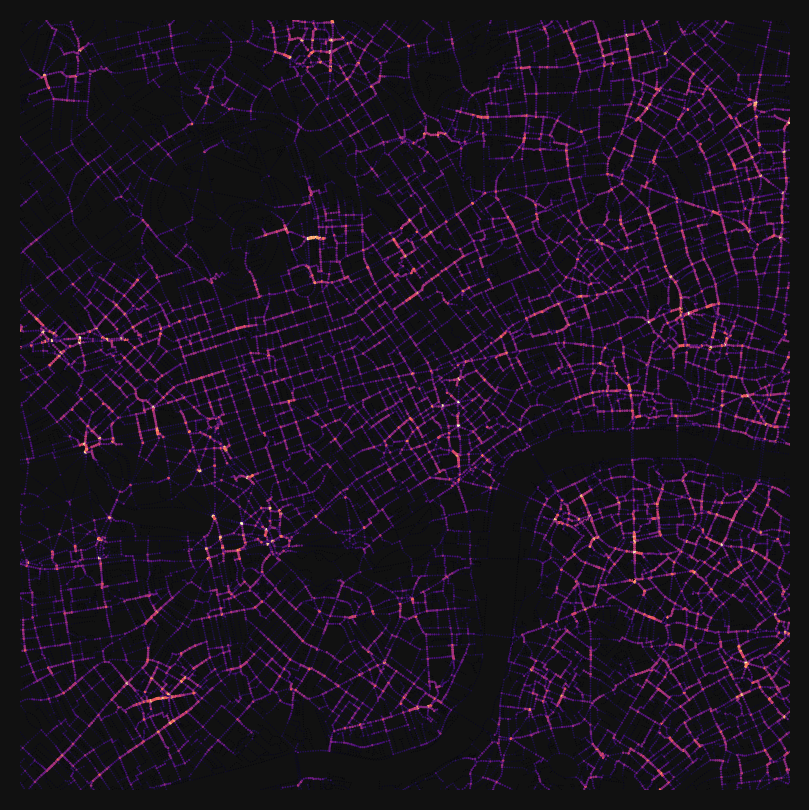


    Spatial impedance weighted betweenness centrality:
    Avg walking tolerance: 702.39m
    Beta: 0.002 (spatial impedance factor)
    Max walking tolerance: 2000.0m
    


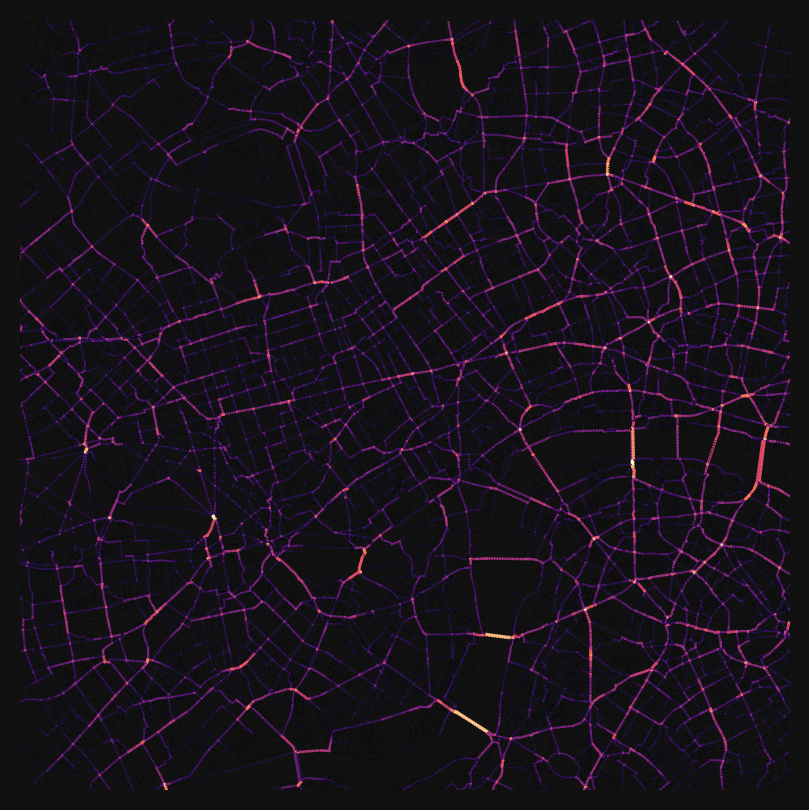

In [5]:
import matplotlib.pyplot as plt
from cityseer import rustalgos
from cityseer.tools import plot

bg_colour = "#111"
distances = [250, 500, 2000]
betas = rustalgos.betas_from_distances(distances)
avg_dists = rustalgos.avg_distances_for_betas(betas)
for d, b, avg_d in zip(distances, betas, avg_dists):
    print(
        f"""
    "Gravity" index / spatial impedance weighted (closeness-like) centrality:
    Avg walking tolerance: {avg_d:.2f}m
    Beta: {b:.3f} (spatial impedance factor)
    Max walking tolerance: {d:.1f}m
    """
    )
    fig, ax = plt.subplots(1, 1, figsize=(5, 5), dpi=200, facecolor=bg_colour)
    plot.plot_scatter(
        ax,
        network_structure.node_xs,
        network_structure.node_ys,
        nodes_gdf[f"cc_metric_node_beta_{d}"],
        bbox_extents=plot_bbox,
        cmap_key="magma",
        face_colour=bg_colour,
    )
    plt.show()

for d, b, avg_d in zip(distances, betas, avg_dists):
    print(
        f"""
    Spatial impedance weighted betweenness centrality:
    Avg walking tolerance: {avg_d:.2f}m
    Beta: {b:.3f} (spatial impedance factor)
    Max walking tolerance: {d:.1f}m
    """
    )
    fig, ax = plt.subplots(1, 1, figsize=(5, 5), dpi=200, facecolor=bg_colour)
    plot.plot_scatter(
        ax,
        network_structure.node_xs,
        network_structure.node_ys,
        nodes_gdf[f"cc_metric_node_betweenness_{d}"],
        bbox_extents=plot_bbox,
        cmap_key="magma",
        s_max=2,
        face_colour=bg_colour,
    )
    plt.show()